# Análise das Etapas de Treinamento de um Algoritmo

## 1.0 Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets as ds
from sklearn import model_selection as ms
from sklearn import tree as tr
from sklearn import metrics as mt

from matplotlib import pyplot as plt

## 2.0 Gerando Dados sintéticos

In [2]:
n_samples = 20000
n_features = 2
n_informative = 2
n_redundant = 0
random_state = 0

X, y = ds.make_classification( n_samples=n_samples,
                        n_features=n_features,
                        n_informative=n_informative,
                        n_redundant=n_redundant,
                        random_state=random_state )

In [3]:
df = pd.DataFrame(X)

df.head()

,0,1
0,2.022874,0.285346
1,0.549895,0.701021
2,-0.659376,0.116066
3,0.967521,-1.060414
4,-1.796434,-2.093534


In [4]:
# dataset de produção
X, X_prod, y, y_prod = ms.train_test_split( X, y, test_size=0.2, random_state=random_state)

## 3.0 Exemplo 1 - Não há separação dos dados

### 3.1 Treinamento e avaliação da performance

In [5]:
# define o modelo
model = tr.DecisionTreeClassifier(max_depth=38)
model.fit(X, y)

# classificação sobre os dados de treinamento
yhat = model.predict(X)

acc = mt.accuracy_score(y, yhat)

print(f"Acurácia sobre treino: {acc}")

Acurácia sobre treino: 1.0


### 3.2 Publicação do modelo em produção

Ao treinar um algoritmo com 100% dos dados, e utilizar este mesmo dataset para teste, o modelo pode se ajustar aos dados treinados. Assim, podemos obter um desempenho impressionante, porém, menos eficaz com os dados em produção. Isto é chamado de 'overfitting'.

Neste momento, o modelo vai apresentar acurácia inferior, pois o dataset de produção é diferente do dataset de treino.

In [6]:
yhat_prod = model.predict(X_prod)
acc_prod = mt.accuracy_score(y_prod, yhat_prod)

print(f"Acurácia sobre produção: {acc_prod}")

Acurácia sobre produção: 0.8535


## 4.0 Exemplo 2 - Estratégia de Treino-Teste

### 4.1 Treinamento e avaliação da performance

In [7]:
# separa os dados em Treinamento e Teste
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=random_state)

In [8]:
# modelo treinado com os dados de treinamento
model = tr.DecisionTreeClassifier(max_depth=38)
model.fit(X_train, y_train)

# classificação sobre os dados de teste
yhat_test = model.predict(X_test)
acc_test = mt.accuracy_score(y_test, yhat_test)

print(f"Acurácia sobre teste: {acc_test}")

Acurácia sobre teste: 0.851875


### 4.2 Escolha dos parâmetros do algoritmo

In [9]:
values = [i for i in range(1, 60)]

test_score = list()

for i in values:
    model = tr.DecisionTreeClassifier(max_depth=i)
    model.fit( X_train, y_train)

    # classificação sobre o teste
    yhat_test = model.predict(X_test)
    acc_test = mt.accuracy_score(y_test, yhat_test)

    test_score.append(acc_test)

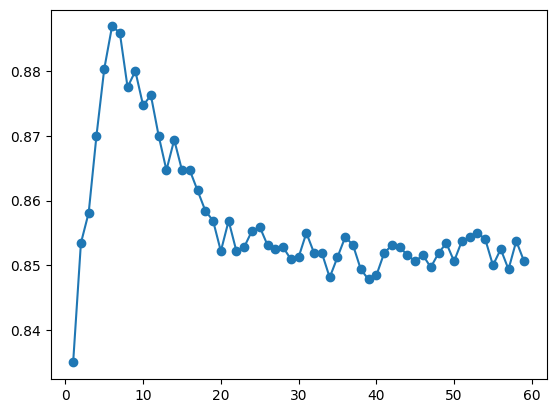

In [10]:
plt.plot(values, test_score, "-o", label="Test")

### 4.3 Publicação do modelo em produção

Desta vez, o modelo foi treinado com 80% dos dados, e 20% foram separados para teste. Portanto, a acurácia apresentada vai ser mais próxima do que é possível alcançar com os dados em produção.

Além disso, foi feito um teste de variação para escolher o melhor parâmetro de profundidade que a árvore pode crescer, de modo que a acurácia seja a melhor possível.

Porém, ao rodar novamente, os dados de treino e teste são concatenados. Os dados de treino e teste já foram utilizados para escolher o melhor parâmetro. É preciso reportar a performance do algoritmo com dados que ele nunca viu. Isto se chama 'vazamento'.

Neste momento, o resultado da acurácia é mais próxima do real, mas ainda não está totalmente adequada. Porém, nem sempre há dados suficientes para isso, sendo assim, em determinados casos, este é o melhor cenário.

In [11]:
# modelo treinado
model_last = tr.DecisionTreeClassifier(max_depth=6)

model_last.fit(np.concatenate((X_train, X_test)),
               np.concatenate((y_train, y_test)))

# classificação sobre os dados de produção
yhat_prod = model_last.predict(X_prod)
acc_prod = mt.accuracy_score(y_prod, yhat_prod)

print(f"Acurácia sobre produção: {acc_prod}")

Acurácia sobre produção: 0.88175


## 5.0 Exemplo 3 - Estratégia de Treino-Validação-Teste

### 5.1 Separação dos dados

In [12]:
# separação entre treino e validação
X_train, X_val, y_train, y_val = ms.train_test_split(X_train, y_train, test_size=0.2)

### 5.2 Escolha dos parâmetros do algoritmo

In [13]:
values = [i for i in range(1, 60)]

val_score = list()

for i in values:
    model = tr.DecisionTreeClassifier(max_depth=i)
    model.fit( X_train, y_train)

    # classificação sobre a validação
    yhat_val = model.predict(X_val)
    acc_val = mt.accuracy_score(y_val, yhat_val)

    val_score.append(acc_val)

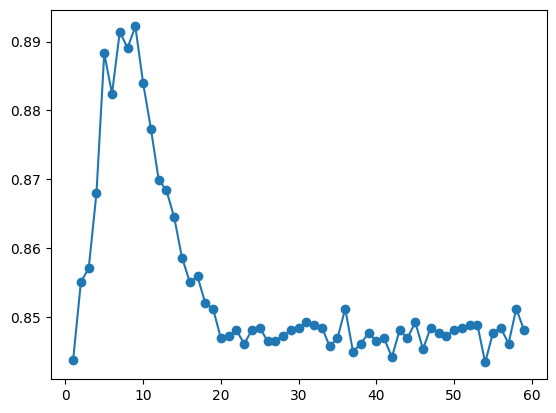

In [14]:
plt.plot(values, val_score, "-o", label="Validação")

### 5.3 Treinamento e avaliação da performance

In [15]:
# previsão sobre os dados de validação
model = tr.DecisionTreeClassifier(max_depth=8)
model.fit(X_train, y_train)

yhat_val = model.predict(X_val)
acc_val = mt.accuracy_score(y_val, yhat_val)

print(f"Acurácia sobre validação: {acc_val}")

Acurácia sobre validação: 0.8890625


### 5.4 Medição da capacidade de generalização

Antes da publicação do modelo em produção, é necessário medir a capacidade de generalização do algoritmo para dados que ele nunca viu. Já utilizamos os dados de treinamento e de validação. Agora vamos usar o dataset de teste. Vamos treinar o modelo com os dados de treino e de validação, e classificar com os dados de teste, que simula os dados em produção.

A acurácia obtida aqui é a que deve ser reportada para a equipe de negócio. Ela é a performance da capacidade de generalização do algoritmo para dados que ele nunca viu.

In [16]:
# modelo treinado sobre training + validation
model_last = tr.DecisionTreeClassifier(max_depth=8)
model_last.fit(np.concatenate((X_train, X_val)),
               np.concatenate((y_train, y_val)))

# classificação sobre os dados de teste
yhat_test = model_last.predict(X_test)
acc_test = mt.accuracy_score(y_test, yhat_test)

print(f"Acurácia sobre teste: {acc_test}")

Acurácia sobre teste: 0.8775


### 5.4 Publicação do modelo em produção

Ao aplicar a estratégia Treino-Validação-Teste, teremos uma performance em produção muito similar à performance em validação.

In [17]:
# classificação sobre os dados de produção
yhat_prod = model_last.predict(X_prod)
acc_prod = mt.accuracy_score(y_prod, yhat_prod)

print(f"Acurácia sobre produção: {acc_prod}")

Acurácia sobre produção: 0.8775
